#### THE DIFFERENT WAYS TO MEASURE VOLATILITY USING PYTHON

In finance, volatility (usually denoted by σ) is the degree of variation of a trading price series over time, usually measured by the standard deviation of logarithmic returns.

Historic volatility measures a time series of past market prices. Implied volatility looks forward in time, being derived from the market price of a market-traded derivative (in particular, an option).

This notebook will show some alternative options when it comes to computing volatility.

We will be using Python, and a few additional modules to complete this project. 

### Step 1: Imports

In [1]:
import math

import numpy as np
import yfinance as yf

In [3]:
data = yf.download("NFLX", start="2017-01-01", end="2022-11-30") # we will use Netflix on a five year time frame as an example

[*********************100%***********************]  1 of 1 completed


Let's quickly plot the 'Close' data so we can see the closing price of Netflix over the past half-decade. 

<AxesSubplot:xlabel='Date'>

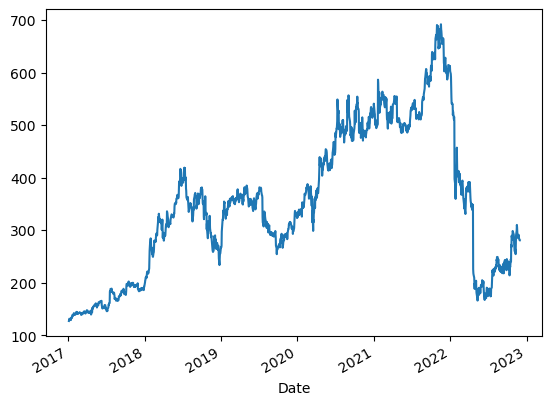

In [5]:
data['Close'].plot()

### Step 2: Computing Volatility

1. Standard Deviation

Standard deviation is the most common way to measure market volatility, and traders often use Bollinger Bands to analyze standard deviation.

In [7]:
def standard_deviation(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    result = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    if clean:
        return result.dropna()
    else:
        return result

A quick plot:

<AxesSubplot:xlabel='Date'>

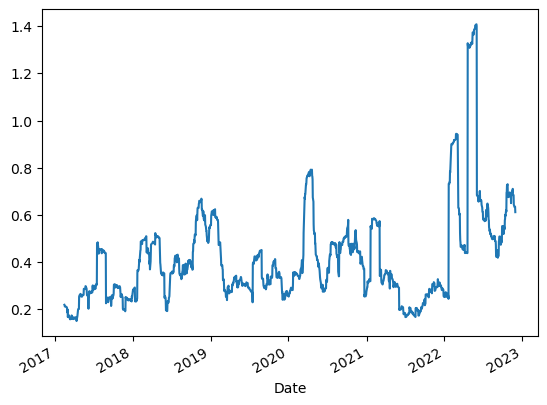

In [8]:
standard_deviation(data).plot()

2. Parkinsons 

Parkinson’s volatility uses the stock’s high and low price of the day rather than just close to close prices. It’s useful to capture large price movements during the day.

In [9]:
def parkinson(price_data, window=30, trading_periods=252, clean=True):

    rs = (1.0 / (4.0 * math.log(2.0))) * (
        (price_data["High"] / price_data["Low"]).apply(np.log)
    ) ** 2.0

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

We take the price data and compute a 30-day rolling volatility metric that we can plot.

<AxesSubplot:xlabel='Date'>

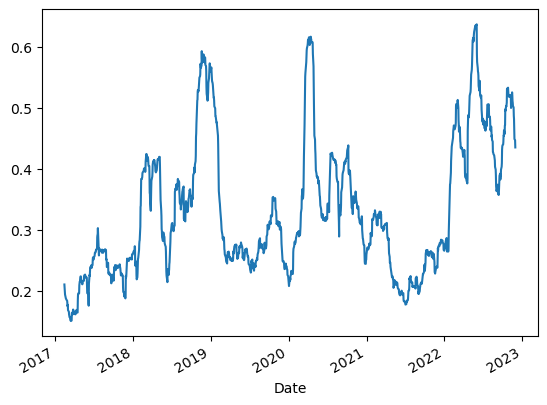

In [10]:
parkinson(data).plot() 

3. Garman-Klass

Garman-Klass volatility extends Parkinson’s volatility by taking into account the opening and closing price. As markets are most active during the opening and closing of a trading session, it makes volatility estimation more accurate.

In [11]:
def garman_klass(price_data, window=30, trading_periods=252, clean=True):

    log_hl = (price_data["High"] / price_data["Low"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = 0.5 * log_hl ** 2 - (2 * math.log(2) - 1) * log_co ** 2

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

Let’s plot it:

<AxesSubplot:xlabel='Date'>

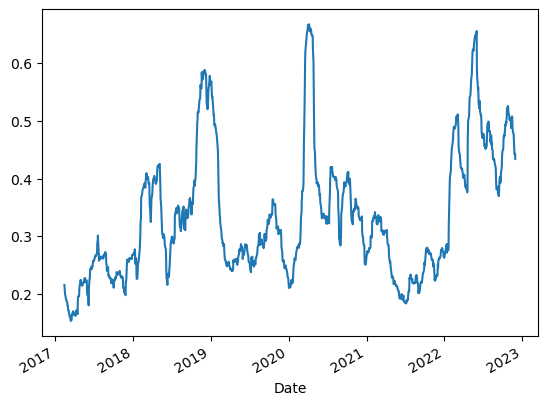

In [12]:
garman_klass(data).plot()

4. Hodges-Tompkins

Hodges-Tompkins volatility is a bias correction for estimation using an overlapping data sample that produces unbiased estimates and a substantial gain in efficiency.

In [14]:
def hodges_tompkins(price_data, window=30, trading_periods=252, clean=True):

    log_return = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)

    vol = log_return.rolling(window=window, center=False).std() * math.sqrt(
        trading_periods
    )

    h = window
    n = (log_return.count() - h) + 1

    adj_factor = 1.0 / (1.0 - (h / n) + ((h ** 2 - 1) / (3 * n ** 2)))

    result = vol * adj_factor

    if clean:
        return result.dropna()
    else:
        return

And to visualize it:

<AxesSubplot:xlabel='Date'>

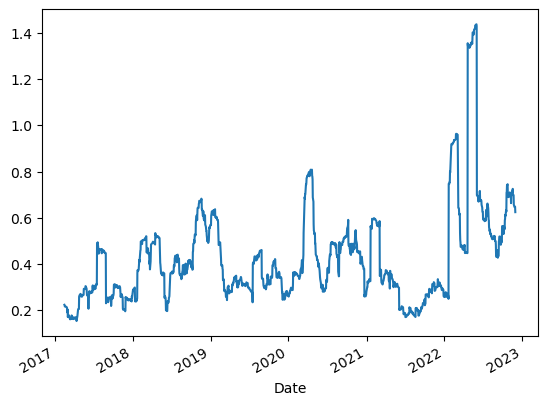

In [15]:
hodges_tompkins(data).plot()

5. Rogers-Satchell

Rogers-Satchell is an estimator for measuring the volatility of securities with an average return not equal to zero. Unlike Parkinson and Garman-Klass estimators, Rogers-Satchell incorporates a drift term (mean return not equal to zero).

In [16]:
def rogers_satchell(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    def f(v):
        return (trading_periods * v.mean()) ** 0.5

    result = rs.rolling(window=window, center=False).apply(func=f)

    if clean:
        return result.dropna()
    else:
        return result

Once again, let’s plot it:

<AxesSubplot:xlabel='Date'>

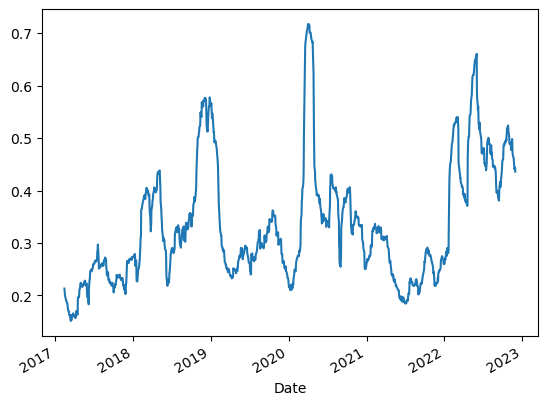

In [18]:
rogers_satchell(data).plot()

6. Yang-Zhang

Yang-Zhang volatility is the combination of the overnight (close-to-open volatility), a weighted average of the Rogers-Satchell volatility and the day’s open-to-close volatility.

In [19]:
def yang_zhang(price_data, window=30, trading_periods=252, clean=True):

    log_ho = (price_data["High"] / price_data["Open"]).apply(np.log)
    log_lo = (price_data["Low"] / price_data["Open"]).apply(np.log)
    log_co = (price_data["Close"] / price_data["Open"]).apply(np.log)

    log_oc = (price_data["Open"] / price_data["Close"].shift(1)).apply(np.log)
    log_oc_sq = log_oc ** 2

    log_cc = (price_data["Close"] / price_data["Close"].shift(1)).apply(np.log)
    log_cc_sq = log_cc ** 2

    rs = log_ho * (log_ho - log_co) + log_lo * (log_lo - log_co)

    close_vol = log_cc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    open_vol = log_oc_sq.rolling(window=window, center=False).sum() * (
        1.0 / (window - 1.0)
    )
    window_rs = rs.rolling(window=window, center=False).sum() * (1.0 / (window - 1.0))

    k = 0.34 / (1.34 + (window + 1) / (window - 1))
    result = (open_vol + k * close_vol + (1 - k) * window_rs).apply(
        np.sqrt
    ) * math.sqrt(trading_periods)

    if clean:
        return result.dropna()
    else:
        return result

Let’s plot it:

<AxesSubplot:xlabel='Date'>

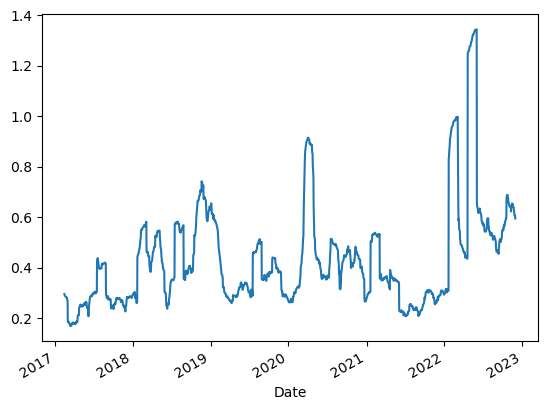

In [20]:
yang_zhang(data).plot()

#### So how do you choose which measure to use?

Each measure has tradeoffs you must consider. 

Most practitioners will choose the one they believe captures the information they think is relevant.

So the best way to decide is experiment, and use them all! 

Each offers different information that when considered in varying contexts may make it very relevant to answering your questions.